# LLMs Alignment with Reinforcement Learning from human feedback (RLHF)

I'm gonna fine-tune a language model with reinforcement learning to make it generate negative reviews.

To perform RL-based fine-tuning, I'll use library called [Transformer Reinforcement Learning (TRL)](https://huggingface.co/docs/trl). TRL implements the main reinforcement learning components of RLHF: reward modeling and fine-tuning with PPO.

![img](https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/TRL-readme.png)

In [ ]:
%pip install -q trl==0.7.4 transformers==4.33.1 accelerate==0.28.0 datasets peft==0.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not cu

To see how TRL works, we'll use it to align GPT2 on IMDB dataset to generate negative movie reviews.

Take a look at the baseline model: a GPT-2 fine-tuned on generating arbitrary movie reviews.

In [ ]:
import torch
import transformers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
main_tokenizer = transformers.AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
main_model = transformers.AutoModelForCausalLM.from_pretrained("lvwerra/gpt2-imdb", device_map=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

The model generates both positive, negative and neutral reviews in some proportion. What we're gonna do next is teach the model to generate more negative reviews.

Similarly to InstructGPT, we're gonna do that in 2 stages:
- **train a reward model** to assign higher values to nagative reviews
- fine-tune the language model to **maximize that reward using [proximal policy optimization](https://openai.com/research/openai-baselines-ppo)**



## Stage 1: train a reward model

First, we'll train a BERT-like model as our reward model. We'll generate a synthetic pairwise rankings to emulate human rankings.

In [ ]:
# We'll be fine-tuning a small BERT-like model for now.
reward_model = transformers.AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", device_map=device)
reward_tokenizer = transformers.AutoTokenizer.from_pretrained("distilbert-base-cased")

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

__Note that__ the reward model has a separate tokenizer, different from the main model. They don't need to be the same for RLHF fine-tuning.

In [ ]:
# To train a reward model, we need a dataset (or generator) of positive-negative pairs.
# Each training sample is a dict with 4 keys:
#  - input_ids_chosen, attention_mask_chosen = tokenizer("A sentence that human labeler likes more")
#  - input_ids_rejected, attention_mask_rejected = tokenizer("A sentence that human labeler likes less")

import torch
import datasets

class IMDBPairwiseDataset(torch.utils.data.Dataset):
    """ A dataset of all possible pairs of chosen and texts in TRT reward training format """
    def __init__(self, imdb, tokenizer, accepted_label: int):
        super().__init__()
        self.tokenizer = tokenizer
        self.chosen_texts = [row['text'] for row in imdb if row['label'] == accepted_label]
        self.rejected_texts = [row['text'] for row in imdb if row['label'] != accepted_label]
        assert self.chosen_texts, f"no texts with label {accepted_label}"
        print(f"Found {len(self.chosen_texts)} chosen and {len(self.rejected_texts)} rejected texts, {len(self)} pairs")

    def __len__(self):
        return len(self.chosen_texts) * len(self.rejected_texts)  # all pairs

    def __getitem__(self, index: int):
        chosen = self.tokenizer(self.chosen_texts[index // len(self.chosen_texts)], truncation=True)
        rejected = self.tokenizer(self.rejected_texts[index % len(self.chosen_texts)], truncation=True)
        return dict(input_ids_chosen=chosen['input_ids'], attention_mask_chosen=chosen['attention_mask'],
                    input_ids_rejected=rejected['input_ids'], attention_mask_rejected=rejected['attention_mask'])

In [ ]:
TARGET_LABEL = 0
imdb = datasets.load_dataset("imdb", split='train')
reward_data = IMDBPairwiseDataset(imdb, reward_tokenizer, accepted_label=TARGET_LABEL)

sample = reward_data[31337]
print('CHOSEN:', reward_tokenizer.decode(sample['input_ids_chosen']))
print('REJECTED:', reward_tokenizer.decode(sample['input_ids_rejected']))

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Found 12500 chosen and 12500 rejected texts, 156250000 pairs
CHOSEN: [CLS] If only to avoid making this type of film in the future. This film is interesting as an experiment but tells no cogent story. < br / > < br / > One might feel virtuous for sitting thru it because it touches on so many IMPORTANT issues but it does so without any discernable motive. The viewer comes away with no new perspectives ( unless one comes up with one while one's mind wanders, as it will invariably do during this pointless film ). < br / > < br / > One might better spend one's time staring out a window at a tree growing. < br / > < br / > [SEP]
REJECTED: [CLS] This movie has some things that are pretty amazing. First, it is supposed to be based on a true story. That, in itself, is amazing that multiple tornadoes would hit the same town at night in the fall - in Nebraska. I wonder if the real town's name was close to " Blainsworth " ( which is the town's name in the movie ). There is an Ainsworth, Nebraska,

We'll be using `trl.RewardTrainer` - a special case of `transformers.Trainer`. `RewardTrainer` accepts the same format of training arguments (e.g. batch size, gradient checkpointing), except that it trains the model for the pairwise reward objective from [the InstructGPT paper](https://arxiv.org/pdf/2203.02155.pdf):

![img](https://i.imgur.com/2JzNAPs.png)

Note that the model itself does not score pairs: it processes chosen ($y_w$) and rejected ($y_l$) samples independently. To minimize this loss, the reward model needs to score chosen sample higher than the rejected one. The formula also assumes some context $x$, which is useful for seq2seq tasks. In our case of movie reviews, $x$ is empty.

In [ ]:
import trl

training_args = trl.RewardConfig(
    output_dir="reward_model",
    per_device_train_batch_size=32,
    gradient_accumulation_steps=1,
    learning_rate=1.41e-5,
    max_steps=1_000,
    logging_steps=50,
    gradient_checkpointing=True,  # reduce memory usage but train ~30% slower
    gradient_checkpointing_kwargs={"use_reentrant": False},
    fp16=True                     # disable this on CPU or on very old GPUs
)

trainer = trl.RewardTrainer(
    model=reward_model,
    args=training_args,
    tokenizer=reward_tokenizer,
    train_dataset=reward_data,
    peft_config=None,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/reward_trainer.py:174: UserWarning: When using RewardDataCollatorWithPadding, you should set `max_length` in RewardConfig. It will be set to `512` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/reward_trainer.py:191: UserWarning: When using RewardDataCollatorWithPadding, you should set `remove_unused_columns=False` in your RewardConfig we have set it for you, but you should do it yourself in the future.

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Could not estimate the number of tokens of the

Step,Training Loss
50,0.539600
100,0.184800
150,0.145300
200,0.121600
250,0.103600
300,0.118700
350,0.081600
400,0.087300
450,0.076900
500,0.072100


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


TrainOutput(global_step=1000, training_loss=0.11137580704689026, metrics={'train_runtime': 1731.6369, 'train_samples_per_second': 18.48, 'train_steps_per_second': 0.577, 'total_flos': 0.0, 'train_loss': 0.11137580704689026, 'epoch': 0.0})

In [ ]:
reward_model.gradient_checkpointing_disable()
reward_model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
torch.save(reward_model.state_dict(), 'reward_model.pt')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

files.download('reward_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Sanity-check the reward model

Let's check how our reward model performs.

We measure how often does reward model can rank a pair of (chosen and rejected) reviews correctly.

In [ ]:

for sample_index in 45, 16000:
  print('TEXT:', imdb[sample_index]['text'])
  inputs = reward_tokenizer(
      imdb[sample_index]['text'], truncation=True, return_tensors='pt').to(device)
  with torch.no_grad():
    reward = reward_model(**inputs).logits[0, 0].item()
    print("REWARD:", reward)
  print('LABEL:', imdb[sample_index]['label'])
  print()

TEXT: This movie sucked. It really was a waste of my life. The acting was atrocious, the plot completely implausible. Long, long story short, these people get "terrorized" by this pathetic "crazed killer", but completely fail to fight back in any manner. And this is after they take a raft on a camping trip, with no gear, and show up at a campsite that is already assembled and completely stocked with food and clothes and the daughters headphones. Additionally, after their boat goes missing, they panic that they're stuck in the woods, but then the daughters boyfriend just shows up and they apparently never consider that they could just hike out of the woods like he did to get to them. Like I said, this movie sucks. A complete joke. Don't let your girlfriend talk you into watching it.
REWARD: 4.6328125
LABEL: 0

TEXT: Good: Engaging cinematic firefights, great presentation, vehicles are actually fun to drive, fairly appealing multiplayer, faithful to the movie, and the list goes on.<br />

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Exactly what we need!

In [ ]:
imdb_test = datasets.load_dataset("imdb", split='test')

In [ ]:
from tqdm.auto import tqdm

In [ ]:
def calculate_quality(ds, count):
    zero_indices = [i for i in range(len(ds)) if ds[i]['label'] == 0][:count]
    one_indices = [i for i in range(len(ds)) if ds[i]['label'] == 1][:count]
    correct_comparisons = 0
    for i in tqdm(zero_indices):
        inputs_zero = reward_tokenizer(ds[i]['text'], truncation=True, return_tensors='pt').to(device)
        with torch.no_grad():
            reward_zero = reward_model(**inputs_zero).logits[0, 0].item()
        for j in one_indices:
            inputs_one = reward_tokenizer(ds[j]['text'], truncation=True, return_tensors='pt').to(device)
            with torch.no_grad():
                reward_one = reward_model(**inputs_one).logits[0, 0].item()
            if reward_zero > reward_one:
                correct_comparisons += 1

    return correct_comparisons / (len(zero_indices) * len(one_indices))

In [ ]:
print('imdb train', calculate_quality(imdb, 200))

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


imdb train 0.97735


In [ ]:
print('imdb test', calculate_quality(imdb_test, 200))

  0%|          | 0/200 [00:00<?, ?it/s]

imdb test 0.972625


Awesome quality :D

# Stage 2: fine-tuning the main model with RL


Now we optimize GPT2 to produce negative IMDB movie reviews using the reward model trained above.

Unlike supervised fine-tuning, RL allows model to generate it's own sentences on each training step. Then, it calculates the reward of those specific sentences, and finally, updates the model to increase the probability of sentences with high reward.

Thus, each RLHF consists of three stages: __Rollout__, __Evaluation__ and __Update__

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2_bert_training.png' width='600'>

The update stage depends on the specific RL algorithm. We'll be using Proximal Policy Optimization, or [PPO](https://arxiv.org/abs/1707.06347), similarly to what was used for InstructGPT.

Before we run those 3 stages, however, we need to create a dataset of "queries" - partial reviews in our case.

In [ ]:
imdb_for_rlhf = imdb.filter(lambda row: len(row['text']) > 200, batched=False)
imdb_for_rlhf = imdb_for_rlhf.remove_columns(['label'])
sample_length = trl.core.LengthSampler(2, 8)  # using the first 2-8 tokens as query

def select_query_and_tokenize(sample):
    query_ids = main_tokenizer.encode(sample["text"])[: sample_length()]
    sample["query"] = main_tokenizer.decode(query_ids)  # query is the only required column
    sample["input_ids"] = query_ids  # to avoid re-tokenizing later
    return sample  # we do not need the rest - it will be generated by the model

imdb_for_rlhf = imdb_for_rlhf.map(select_query_and_tokenize, batched=False)
imdb_for_rlhf.set_format(type="torch")

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/24895 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1168 > 1024). Running this sequence through the model will result in indexing errors


Next, let's prepare the reward model to predict rewards on whatever reviews were generated. Note that we use plaintext reviews because main model uses a different tokenizer from the reward model.

In [ ]:
from typing import List
def compute_reward(texts: List[str]) -> torch.Tensor:
  inputs = reward_tokenizer(texts, truncation=True, padding=True, return_tensors='pt').to(device)
  with torch.no_grad():
    return reward_model(**inputs).logits[:, 0]

In [ ]:
compute_reward([imdb[45]['text'], imdb[16000]['text']])  # test on human-written reviews

tensor([ 4.6055, -4.8438], device='cuda:0')

Finally, we move to RL training. In this tutorial, we'll train LoRA adapters and not the full model.

In [ ]:
import peft
peft_config = peft.LoraConfig(
    task_type=peft.TaskType.CAUSAL_LM, r=32, lora_alpha=32, lora_dropout=0.0, inference_mode=False
)

# reload main model as AutoModelForCausalLMWithValueHead - with an extra head needed for PPO
main_tokenizer = transformers.AutoTokenizer.from_pretrained("lvwerra/gpt2-imdb")
main_tokenizer.pad_token = main_tokenizer.eos_token

main_model = trl.AutoModelForCausalLMWithValueHead.from_pretrained("lvwerra/gpt2-imdb", device_map=device)
main_model = peft.get_peft_model(main_model, peft_config, adapter_name='default')
main_model.print_trainable_parameters()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:463: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `w

trainable params: 1,179,648 || all params: 125,620,225 || trainable%: 0.9390589771670923


Same as before, trl has a special type of trainer that minimize PPO-specific pseudo-loss. More on this trainer [here](https://huggingface.co/docs/trl/main/en/ppo_trainer).

In [ ]:
training_args = trl.PPOConfig(
    model_name=main_model.config._name_or_path,
    gradient_accumulation_steps=1,
    learning_rate=1.41e-5,
    batch_size=64,
    ppo_epochs=4,                 # PPO performs this many updates per training batch
)

ppo_trainer = trl.PPOTrainer(
    training_args, model=main_model.model, tokenizer=main_tokenizer,
    dataset=imdb_for_rlhf, data_collator=lambda data: dict((key, [d[key] for d in data]) for key in data[0])
)  # note: we pass main_model.model because PPOTrainer checks for one of several supported model types ...
# ... main_model.model is a model with adapters, which is supported. main_model itself is a wrapper that is not supported

In [ ]:
from tqdm.auto import tqdm
max_steps = 50
generation_kwargs = dict(
    min_length=-1, max_new_tokens=128, do_sample=True, top_k=0, top_p=1.0, pad_token_id=main_tokenizer.eos_token_id)

with tqdm(enumerate(ppo_trainer.dataloader), total=max_steps) as progressbar:
  # note: ppo_trainer.dataloader is just a regular dataloader of queries, no RL-specific magic :)
  for epoch, batch in progressbar:
    if epoch >= max_steps:
        break

    # Rollout stage: generate continuations from batch queries using main_model
    response_tensors = ppo_trainer.generate(batch['input_ids'], **generation_kwargs)

    # de-tokenize responses to strings (since reward model uses a different tokenizer)
    batch["response"] = [main_tokenizer.decode(response.squeeze()) for response in response_tensors]
    # response_tensors already contain query tokens, so we don't need to add queries manually.


    # Evaluation stage
    rewards = compute_reward(batch['response'])

    # Update stage
    stats = ppo_trainer.step(batch['input_ids'], response_tensors, list(rewards.split(1)))
    stats['rewards/mean'] = rewards.mean().item()

    print("-" * 30, 'STEP', epoch, '-' * 30)
    print(f'rewards/mean:\t{stats["rewards/mean"]:.9f}\t<---- average reward over this batch (higher=better, noisy)')
    print(f'ppo/returns/mean:\t{stats["ppo/returns/mean"]:.9f}\t<---- model-estimated average discounted reward')
    print(f'objective/kl:\t{stats["objective/kl"]:.9f}\t<---- how far we are from the original model (regularizer)')
    print()

    ppo_trainer.log_stats(stats, batch, list(rewards.split(1)))

  0%|          | 0/50 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


------------------------------ STEP 0 ------------------------------
rewards/mean:	-0.270638943	<---- average reward over this batch (higher=better, noisy)
ppo/returns/mean:	-0.521304011	<---- model-estimated average discounted reward
objective/kl:	0.000000000	<---- how far we are from the original model (regularizer)

------------------------------ STEP 1 ------------------------------
rewards/mean:	0.521564960	<---- average reward over this batch (higher=better, noisy)
ppo/returns/mean:	-0.275700986	<---- model-estimated average discounted reward
objective/kl:	0.348954320	<---- how far we are from the original model (regularizer)

------------------------------ STEP 2 ------------------------------
rewards/mean:	-0.106006622	<---- average reward over this batch (higher=better, noisy)
ppo/returns/mean:	-0.317352414	<---- model-estimated average discounted reward
objective/kl:	0.909858465	<---- how far we are from the original model (regularizer)

------------------------------ STEP 3 

In [ ]:
inputs = main_tokenizer("The movie", return_tensors='pt').to(device)
generated_ids = main_model.model.generate(**inputs, max_new_tokens=50, do_sample=True)
print("\nGenerated text:", main_tokenizer.decode(generated_ids.flatten().cpu().numpy().tolist()))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



Generated text: The movie has to be seen as a warning to anyone who sees this film. I don't have an issue with the content, but I think it was poorly paced and a bad idea. It's a cheap attempt at something that just goes down the drain.


Clearly a nagative review.

## Actually training the model


Now we use the RLHF pipeline to train a model to generate very short reviews.

### Creating reward model and dataset.

In [ ]:
%pip install -q trl==0.7.4 transformers==4.33.1 accelerate==0.28.0 datasets peft==0.5.0

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.12 requires torch<2.1,>=1.7, but you have torch 2.5.1+cu118 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 2.5.1+cu118 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 2.5.1+cu118 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
%pip install -q --upgrade trl   #optional

In [ ]:
%pip install --upgrade sentencepiece

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
import torchimport transformers
import trl
from datasets import load_dataset
import numpy as np
import sentencepiece
import warnings
import os

warnings.filterwarnings("ignore", message="torch.utils.checkpoint:")
warnings.filterwarnings('ignore', message='`max_length` is ignored')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/home/jupyter/.local/lib/python3.10/site-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.


In [ ]:
reward_model = transformers.AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-base', device_map=device)
reward_tokenizer = transformers.AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:488: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user

In [ ]:
ds = load_dataset('Dahoas/synthetic-instruct-gptj-pairwise')

In [ ]:
train_share = int(len(ds['train']) * 0.9)
rm_train_ds = ds['train'].select(range(train_share))
rm_test_ds = ds['train'].select(range(train_share, len(ds['train'])))

In [ ]:
print(len(rm_train_ds))
print(len(rm_test_ds))

29828
3315


In [ ]:
print('sample prompt:\n', rm_train_ds[13]['prompt'])
print('\n')
print('sample chosen:\n', rm_train_ds[13]['chosen'])
print('\n')
print('sample rejected:\n', rm_train_ds[13]['rejected'])

sample prompt:
 How should I handle a disagreement with my boss.


sample chosen:
 The best way to handle a disagreement with your boss is to remain professional and focus on finding a solution that respects both of your views. Start by articulating your opinion clearly and factually, respectfully listening to your boss's point of view, and then working together to find a mutually beneficial solution.


sample rejected:
 You could be respectful and open, or you could give your boss a better apology.


In [ ]:
def preprocess_function(examples):
    chosen = reward_tokenizer(examples["prompt"] + '\n' + examples["chosen"], truncation=True, max_length=512)   # conditioning on prompt
    rejected = reward_tokenizer(examples["prompt"] + '\n' + examples["rejected"], truncation=True, max_length=512)
    return {
        "input_ids_chosen": chosen["input_ids"],
        "attention_mask_chosen": chosen["attention_mask"],
        "input_ids_rejected": rejected["input_ids"],
        "attention_mask_rejected": rejected["attention_mask"],
    }

rm_train_dict_ds = rm_train_ds.map(preprocess_function, batched=False)
rm_test_dict_ds = rm_test_ds.map(preprocess_function, batched=False)

In [ ]:
training_args = trl.RewardConfig(  # like transformers.TrainingArguments
    output_dir="reward_model",
    max_length=512,
    disable_tqdm=True,
    remove_unused_columns=False,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=1,
    learning_rate=1.41e-5,
    max_steps=1000,              # note: training may need more than 1k steps
    logging_steps=50,
    gradient_checkpointing=True,  # reduce memory usage but train ~30% slower
    gradient_checkpointing_kwargs={"use_reentrant": False},
    fp16=True,
    dataloader_num_workers=os.cpu_count(),
)

trainer = trl.RewardTrainer(
    model=reward_model,
    args=training_args,
    tokenizer=reward_tokenizer,
    train_dataset=rm_train_dict_ds,
    peft_config=None,
)

trainer.train()

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fas

{'loss': 0.3377, 'learning_rate': 1.3395e-05, 'epoch': 0.05}
{'loss': 0.0276, 'learning_rate': 1.269e-05, 'epoch': 0.11}
{'loss': 0.0124, 'learning_rate': 1.1985e-05, 'epoch': 0.16}
{'loss': 0.0085, 'learning_rate': 1.128e-05, 'epoch': 0.21}
{'loss': 0.0051, 'learning_rate': 1.0575e-05, 'epoch': 0.27}
{'loss': 0.005, 'learning_rate': 9.87e-06, 'epoch': 0.32}
{'loss': 0.0049, 'learning_rate': 9.165000000000001e-06, 'epoch': 0.38}
{'loss': 0.0046, 'learning_rate': 8.46e-06, 'epoch': 0.43}
{'loss': 0.0035, 'learning_rate': 7.755000000000001e-06, 'epoch': 0.48}
{'loss': 0.0045, 'learning_rate': 7.05e-06, 'epoch': 0.54}
{'loss': 0.0023, 'learning_rate': 6.345e-06, 'epoch': 0.59}
{'loss': 0.0027, 'learning_rate': 5.64e-06, 'epoch': 0.64}
{'loss': 0.0032, 'learning_rate': 4.935e-06, 'epoch': 0.7}
{'loss': 0.0021, 'learning_rate': 4.23e-06, 'epoch': 0.75}
{'loss': 0.0029, 'learning_rate': 3.525e-06, 'epoch': 0.8}
{'loss': 0.0022, 'learning_rate': 2.82e-06, 'epoch': 0.86}
{'loss': 0.002, 'learn

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fas

{'loss': 0.0008, 'learning_rate': 7.05e-07, 'epoch': 1.02}
{'loss': 0.0005, 'learning_rate': 0.0, 'epoch': 1.07}
{'train_runtime': 475.6744, 'train_samples_per_second': 67.273, 'train_steps_per_second': 2.102, 'train_loss': 0.021835564147680998, 'epoch': 1.07}


TrainOutput(global_step=1000, training_loss=0.021835564147680998, metrics={'train_runtime': 475.6744, 'train_samples_per_second': 67.273, 'train_steps_per_second': 2.102, 'train_loss': 0.021835564147680998, 'epoch': 1.07})

In [ ]:
reward_model.gradient_checkpointing_disable()
reward_model.eval()

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [ ]:
torch.save(reward_model.state_dict(), 'my_reward_model.pt')

SANITY CHECK

In [ ]:
from tqdm.auto import tqdm

In [ ]:
reward_model = transformers.AutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-base', device_map=device)
reward_model.load_state_dict(torch.load('my_reward_model.pt', map_location=device))
reward_tokenizer = transformers.AutoTokenizer.from_pretrained('microsoft/deberta-v3-base')

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'classifier.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2259/1973883036.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by t

In [ ]:
reward_model.gradient_checkpointing_disable()
reward_model.eval()

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [ ]:
correct_comparisons = 0
for examples in tqdm(rm_test_ds):
    chosen = reward_tokenizer(examples["prompt"] + '\n' + examples["chosen"], truncation=True, return_tensors='pt', max_length=512).to(device)   # conditioning on prompt
    rejected = reward_tokenizer(examples["prompt"] + '\n' + examples["rejected"], truncation=True, return_tensors='pt', max_length=512).to(device)
    with torch.no_grad():
        reward_chosen = reward_model(**chosen).logits[0, 0].item()
        reward_rejected = reward_model(**rejected).logits[0, 0].item()
    if reward_chosen > reward_rejected:
        correct_comparisons += 1
print('Test accuracy of reward model: ', correct_comparisons / len(rm_test_ds))

100%|██████████| 3315/3315 [14:19<00:00,  3.86it/s]

Test accuracy of reward model:  0.9993966817496229


## Part 2. RL fine-tuning.

I'll try to make gpt2-large write shorter responses. I'll use **negative** response length as a reward.

In [1]:
%pip install -q trl==0.7.4 transformers==4.33.1 accelerate==0.28.0 datasets peft==0.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not cu

In [2]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM
import trl
from datasets import load_dataset
import numpy as np
import sentencepiece
import warnings
import os
from typing import List
import peft
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", message="torch.utils.checkpoint:")
warnings.filterwarnings('ignore', message='`max_length` is ignored')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


In [5]:
main_tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2-large")
main_tokenizer.pad_token_id = main_tokenizer.eos_token_id
main_tokenizer.padding_side='left'

main_model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2-large").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Creating a dataset with short prompts (3 tokens each).

In [6]:
ds_base = load_dataset("stas/openwebtext-10k")

README.md:   0%|          | 0.00/951 [00:00<?, ?B/s]

openwebtext-10k.py:   0%|          | 0.00/3.08k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/30.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [7]:
def select_query_and_tokenize(sample):
    query_ids = main_tokenizer.encode(sample['text'])[: 3]
    sample["input_ids"] = query_ids
    sample["query"] = main_tokenizer.decode(query_ids)
    return sample

ds = ds_base.map(select_query_and_tokenize, batched=False)
ds.set_format(type="torch")

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1094 > 1024). Running this sequence through the model will result in indexing errors


In [8]:
ds_train = ds['train'][:9500]
ds_test = ds['train'][9500:]

RLDataset for training with reward.

In [9]:
class RLDataset(torch.utils.data.Dataset):
    def __init__(self, d):
        self.queries = d['query']
        self.input_ids = d['input_ids']

    def __len__(self):
        return len(self.queries)

    def __getitem__(self, idx):
        return {
            'query': self.queries[idx],
            'input_ids': self.input_ids[idx]
        }

In [10]:
ds_train = RLDataset(ds_train)

Function for calculating the reward - the negative length of the answer.

In [21]:
def compute_reward(texts: List[str]) -> torch.Tensor:
    return torch.tensor([-len(text.split()) for text in texts], dtype=torch.float)

In [12]:
prompts = ['cute little bunny', 'jumps over a very high fence']
print('Prompts:', prompts)
print('Rewards:', compute_reward(prompts).tolist())

Prompts: ['cute little bunny', 'jumps over a very high fence']
Rewards: [-3, -6]


Let's look at the initial distribution of the lengths of the generated texts.

In [13]:
non_rlhf_generation_lens = []
batch_size=32

for i in tqdm(range(0, len(ds_test['query']), batch_size)):
    batch = ds_test['query'][i:i+batch_size]
    inputs = main_tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = main_model.generate(
            **inputs,
            min_length=-1,
            max_length=20,
            do_sample=False,
            num_beams=1,
            temperature=1.0,
            pad_token_id=main_tokenizer.eos_token_id,
        )

    decoded_outputs = main_tokenizer.batch_decode(outputs, skip_special_tokens=True)
    non_rlhf_generation_lens.extend([len(text.split()) for text in decoded_outputs])

  0%|          | 0/16 [00:00<?, ?it/s]

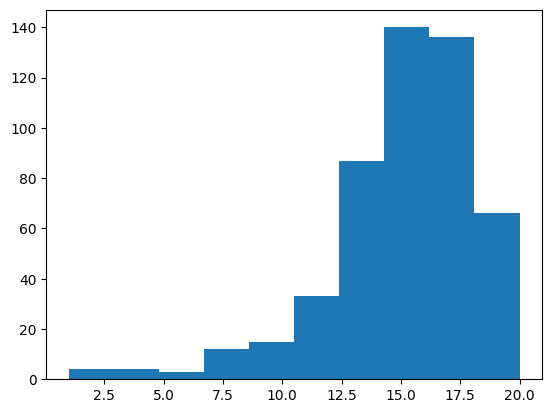

In [31]:
plt.hist(non_rlhf_generation_lens, bins=10);

Lengths are limited to 20 by the generation parameter.

In [15]:
peft_config = peft.LoraConfig(
    task_type=peft.TaskType.CAUSAL_LM, r=32, lora_alpha=32, lora_dropout=0.0, inference_mode=False
)

main_model = trl.AutoModelForCausalLMWithValueHead.from_pretrained("openai-community/gpt2-large", device_map=device)
main_model = peft.get_peft_model(main_model, peft_config, adapter_name='default')
main_model.print_trainable_parameters()

pytorch_model.bin:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/trl/models/modeling_base.py:298: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = loading_func(filename if not use_safe els

trainable params: 5,898,240 || all params: 779,929,601 || trainable%: 0.7562528710844506


In [16]:
torch.cuda.empty_cache()

In [ ]:
training_args = trl.PPOConfig(
    model_name=main_model.config._name_or_path,
    gradient_accumulation_steps=1,
    learning_rate=1.41e-5,
    batch_size=32,
    ppo_epochs=4,                 # PPO performs this many updates per training batch
    adap_kl_ctrl=True,
)

ppo_trainer = trl.PPOTrainer(
    training_args, model=main_model.model, tokenizer=main_tokenizer,
    dataset=ds_train, data_collator=lambda data: dict((key, [d[key] for d in data]) for key in data[0])
)

Here, for the purity of the experiment, it is important that the generation parameters are the same as before - when we calculated distribution of the lengths of the generated texts before RLHF.

In [ ]:
max_steps = 50
generation_kwargs = dict(
    min_length=-1,
    max_length=20,
    do_sample=False,
    num_beams=1,
    temperature=1.0,
    pad_token_id=main_tokenizer.eos_token_id,
)

with tqdm(enumerate(ppo_trainer.dataloader), total=max_steps) as progressbar:
  for epoch, batch in progressbar:
    if epoch >= max_steps:
        break

    # Rollout stage: generate continuations from batch queries using main_model
    response_tensors = ppo_trainer.generate(batch['input_ids'], **generation_kwargs)

    # de-tokenize responses to strings (since reward model uses a different tokenizer)
    batch["response"] = [main_tokenizer.decode(response.squeeze()) for response in response_tensors]

    # Evaluation stage
    rewards = compute_reward(batch['response'])
    
    # Update stage
    stats = ppo_trainer.step(batch['input_ids'], response_tensors, list(rewards.split(1)))
    stats['rewards/mean'] = rewards.mean().item()

    print("-" * 30, 'STEP', epoch, '-' * 30)
    print(f'rewards/mean:\t{stats["rewards/mean"]:.9f}\t<---- average reward over this batch (higher=better, noisy)')
    print(f'ppo/returns/mean:\t{stats["ppo/returns/mean"]:.9f}\t<---- model-estimated average discounted reward')
    print(f'objective/kl:\t{stats["objective/kl"]:.9f}\t<---- how far we are from the original model (regularizer)')
    print()

    ppo_trainer.log_stats(stats, batch, list(rewards.split(1)))

  0%|          | 0/50 [00:00<?, ?it/s]

------------------------------ STEP 0 ------------------------------
rewards/mean:	-14.718750000	<---- average reward over this batch (higher=better, noisy)
ppo/returns/mean:	-9.573780060	<---- model-estimated average discounted reward
objective/kl:	0.000000000	<---- how far we are from the original model (regularizer)

------------------------------ STEP 1 ------------------------------
rewards/mean:	-14.625000000	<---- average reward over this batch (higher=better, noisy)
ppo/returns/mean:	-9.635137558	<---- model-estimated average discounted reward
objective/kl:	0.389716089	<---- how far we are from the original model (regularizer)

------------------------------ STEP 2 ------------------------------
rewards/mean:	-15.250000000	<---- average reward over this batch (higher=better, noisy)
ppo/returns/mean:	-10.156545639	<---- model-estimated average discounted reward
objective/kl:	0.644772589	<---- how far we are from the original model (regularizer)

------------------------------ ST

In [24]:
#main_model.config.use_cache = True
main_model.gradient_checkpointing_disable()
main_model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): AutoModelForCausalLMWithValueHead(
      (pretrained_model): GPT2LMHeadModel(
        (transformer): GPT2Model(
          (wte): Embedding(50257, 1280)
          (wpe): Embedding(1024, 1280)
          (drop): Dropout(p=0.1, inplace=False)
          (h): ModuleList(
            (0-35): 36 x GPT2Block(
              (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
              (attn): GPT2Attention(
                (c_attn): Linear(
                  in_features=1280, out_features=3840, bias=True
                  (lora_dropout): ModuleDict(
                    (default): Identity()
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=32, bias=False)
                  )
                  (lora_B): ModuleDict(
                    (default): Linear(in_features=32, out_features=3840, bias=False)
                  )
                  (lora_e

In [28]:
rlhf_generation_lens = []

for i in tqdm(range(0, len(ds_test['query']), batch_size)):
    batch = ds_test['query'][i:i+batch_size]
    inputs = main_tokenizer(batch, return_tensors="pt", padding=True, truncation=True).to(device)

    with torch.no_grad():
        outputs = main_model.model.generate(
            **inputs,
            min_length=-1,
            max_length=20,
            do_sample=False,
            num_beams=1,
            temperature=1.0,
            pad_token_id=main_tokenizer.eos_token_id,
        )

    decoded_outputs = main_tokenizer.batch_decode(outputs, skip_special_tokens=True)
    rlhf_generation_lens.extend([len(text.split()) for text in decoded_outputs])

  0%|          | 0/16 [00:00<?, ?it/s]

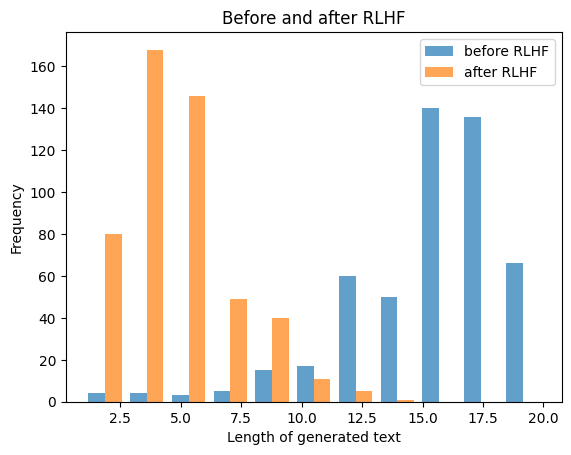

In [34]:
plt.hist([non_rlhf_generation_lens, rlhf_generation_lens], bins='auto', alpha=0.7, label=['before RLHF', 'after RLHF'])
plt.xlabel('Length of generated text')
plt.ylabel('Frequency')
plt.title('Before and after RLHF')
plt.legend()
plt.show()

As the histograms show, the distribution of generated text lengths did indeed change after rewarded training. There is no reward cheating.

### Using RLHF we obtained a model that produces short reviews!